In [1]:
import torch
import torchvision.transforms as T
import torch.nn as nn
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from einops import rearrange
import matplotlib.pyplot as plt

Here we want to create a validation set from the train set. We want a 85% train and 15%, keeping the labels proportionality

In [2]:
TRAIN_CSV = 'csv/EPIC_100_train.csv'
VAL_CSV = 'csv/EPIC_100_validation.csv'

### Original df

In [3]:
df = pd.read_csv(TRAIN_CSV)
df.head(5)

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114]
2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8]
3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13]
4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3]


In [18]:
def count_frames(row):
    f = row['stop_frame'] - row['start_frame']
    return f

In [19]:
df['frames'] = df.apply(lambda row: count_frames(row), axis=1)

In [21]:
df[df['verb_class']==0]['frames'].mean()

94.45130657327586

In [22]:
df[df['verb_class']==1]['frames'].mean()

97.76368098159509

In [23]:
df[df['verb_class']==2]['frames'].mean()

307.3786632019633

In [24]:
df[df['verb_class']==3]['frames'].mean()

104.71088295687885

In [27]:
df.shape

(67217, 15)

In [28]:
df['verb_class'].apply(lambda x: int(x))

0         3
1         6
2         3
3         0
4         3
         ..
67212     8
67213     0
67214     9
67215    30
67216    30
Name: verb_class, Length: 67217, dtype: int64

In [29]:
df = df.drop(df[df['video_id'] == 'P23_04'].index)

## Create splits and new train/val dfs

In [30]:
verbs = df['verb_class'].unique()

In [31]:
df_verb_train_list = []
df_verb_val_list = []
for verb in verbs:
    if len(df[df['verb_class'] == verb]) >= 2:
        df_verb = df[df['verb_class'] == verb]
        df_verb_train, df_verb_val = train_test_split(df_verb, test_size=0.15, train_size=0.85, random_state=1, shuffle=True)
        df_verb_train_list.append(df_verb_train)
        df_verb_val_list.append(df_verb_val)
    else:
        print(f'verb {verb} skipped. Only {len(df[df["verb_class"] == verb])} values')

verb 93 skipped. Only 1 values


In [32]:
df_train = pd.concat(df_verb_train_list)
df_val = pd.concat(df_verb_val_list)

In [33]:
df_train['verb_class'].value_counts()

verb_class
0     12580
1     10381
2      5865
3      4134
4      2954
      ...  
92        3
94        2
95        1
96        1
90        1
Name: count, Length: 96, dtype: int64

In [34]:
verbs_ds = df_train['verb_class'].value_counts()

In [35]:
verbs_freq = np.asarray(verbs_ds)
labels = verbs_ds.index

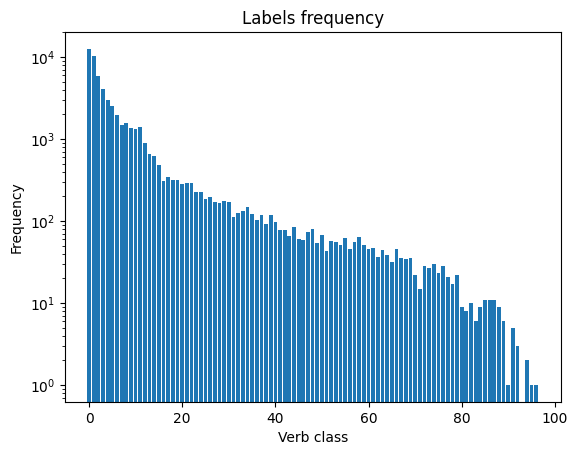

In [36]:
plt.bar(labels, height=verbs_freq)
plt.title('Labels frequency')
plt.xlabel('Verb class')
plt.ylabel('Frequency')
plt.yscale('log')
plt.savefig('labels_hist_original')

We have to make the classes to be in order of [0, 1, 2, .., 96]. Now in the last labels we have [0, ..., 92, 94, 95, 96] which raises an error.

In [ ]:
for num in [94, 95, 96]:
    for index in df_train['verb_class'][df_train['verb_class'] == num].index:
        df_train.loc[index, 'verb_class'] = num-1

In [ ]:
for num in [94, 95, 96]:
    for index in df_val['verb_class'][df_val['verb_class'] == num].index:
        df_val.loc[index, 'verb_class'] = num-1

In [ ]:
df_train['verb_class'].unique()

In [ ]:
df_val['verb_class'].unique()

In [ ]:
# shuffle the rows
df_train = df_train.sample(frac = 1)
df_val = df_val.sample(frac = 1)

In [ ]:
print(f'df train shape: {df_train.shape}')
print(f'df val shape: {df_val.shape}')

In [ ]:
df_train['verb_class'].value_counts()

In [ ]:
df_val['verb_class'].value_counts()

In [ ]:
df_val.head()

In [ ]:
df_train.to_csv('train.csv')
df_val.to_csv('val.csv')

## weight for classes exporation

In [ ]:
unique_labels = np.array(df_train['verb_class'].unique())
unique_labels.sort()
all_labels = np.array(df_train['verb_class'])

In [ ]:
print(unique_labels)

In [ ]:
all_labels

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=all_labels)

In [ ]:
class_weights

In [ ]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
class_weights_tensor.dtype

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Generate subset to make trial

In [43]:
df = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(VAL_CSV)

In [44]:
df_lst = []
for label in range(4):
    df_label = df[df['verb_class'] == label]
    df_lst.append(df_label)
df_subset = pd.concat(df_lst)

In [45]:
df_subset.shape

(38870, 15)

In [46]:
df_subset.shape[0] / df.shape[0]

0.5782763289048901

In [42]:
df_subset = df_subset.sample(frac=0.05)

In [15]:
df_subset.shape

(1944, 15)

In [16]:
df_subset['verb_class'].value_counts()

verb_class
0    721
1    669
2    342
3    212
Name: count, dtype: int64

In [26]:
df_subset_train, df_subset_val = train_test_split(df_subset, test_size=0.15, train_size=0.85, random_state=1, shuffle=True)

In [32]:
df_subset_train.to_csv('subset_train.csv')
df_subset_val.to_csv('subset_val.csv')

In [34]:
df_subset_train['verb_class'].unique()

array([1, 3, 0, 2], dtype=int64)

In [4]:
df_lst = []
for label in range(4):
    df_label = df_test[df_test['verb_class'] == label]
    df_lst.append(df_label)
df_test_subset = pd.concat(df_lst)

In [5]:
df_test_subset = df_test_subset.sample(frac=0.05)

In [7]:
df_test_subset.shape

(280, 15)

In [9]:
df_test_subset['verb_class'].value_counts()

verb_class
0    96
1    81
2    62
3    41
Name: count, dtype: int64

In [10]:
df_test_subset.to_csv('subset_test.csv')

## Custom sets analysis

In [48]:
custom_train = 'csv/subset_train.csv'
custom_val = 'csv/subset_val.csv'
custom_test = 'csv/subset_test.csv'

In [49]:
df_train = pd.read_csv(custom_train)
df_val = pd.read_csv(custom_val)
df_test = pd.read_csv(custom_test)

In [50]:
print(f'custom train shape: {df_train.shape}')
print(f'custom val shape: {df_val.shape}')
print(f'custom test shape: {df_test.shape}')

custom train shape: (1648, 16)
custom val shape: (291, 16)
custom test shape: (280, 16)


In [58]:
len(df_test['video_id'].unique())

85

In [17]:
train_labels = df_train['verb_class'].value_counts()

In [19]:
verbs_freq = np.asarray(train_labels)
labels = train_labels.index

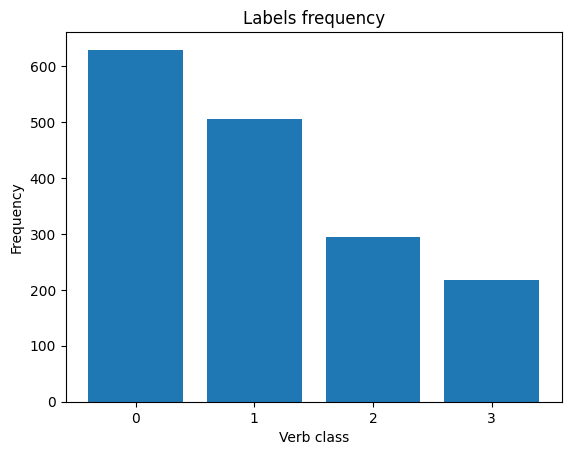

In [24]:
plt.bar(labels, height=verbs_freq, tick_label=[x for x in range(4)])
plt.title('Labels frequency')
plt.xlabel('Verb class')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.savefig('labels_hist')